# Enhancing VAE Performance with Barlow Twins: Self-Supervised Learning for Improved Image Inpainting

1. **Dane wejściowe**

    W zadaniu wykorzystany zostanie zbiór [Nature](https://www.kaggle.com/datasets/heyitsfahd/nature). Posiada on 100 956 obrazów o rozmiarach 64x64 i kolorze RGB, które należą do 4 klas: Miasto, Góry, Ogień i Jezior. Oprócz tego zostaną wygenerowane dodatkowe *uszkodzone* obrazy, czyli *oryginalne* zdjęcia z nałożonym w losowym miejscu czarnym kwadratem symbolizującym ubytek.

    Wejście do modelu będzie stanowić: X - zdjęcie *uszkodzone*, a uczony on będzie przy pomocy: Y - zdjęcie *oryginalne*.

2. **Dane wyjściowe**

    Na wyjściu autokodera zostanie wygenerowane zdjęcie uzupełnione, które będzie dążyć do maksymalnej zgodności z *oryginalnym* obrazem Y.

3. **Cel**

    Celem jest `inpainting` - zadanie rekonstrukcji obrazu, w którym brakujące fragmenty lub uszkodzone obszary zdjęć są uzupełniane w sposób zgodny z otaczającym kontekstem, tak aby uzyskać wizualnie spójny i realistyczny obraz.

4. **Hipoteza badawcza** ToDo

    Zastosowanie metody `Bootstrap Your Own Latent (BYOL)` do treningu enkodera modelu `Variational Autoencoder (VAE)` doprowadzi do poprawy jego wydajności w zadaniu inpaintingu obrazów.

5. **Opis metod**  ToDo

    ![Architektura BYOL](resources\byol_architecture.png) \
    *Grafika z [publikacji](https://arxiv.org/pdf/2006.07733)*

    `Bootstrap Your Own Latent (BYOL)` - [Bootstrap Your Own Latent A New Approach to Self-Supervised Learning](https://arxiv.org/pdf/2006.07733) - to metoda samo-nadzorowanego uczenia maszynowego używana do trenowania modeli bez potrzeby etykietowania danych. Model tworzy dwie wersje danych wejściowych poprzez losowe augmentacje, które są następnie przetwarzane przez dwa enkodery: online i target. Reprezentacje uzyskane z tych enkoderów są przetwarzane przez prostą sieć MLP, która pełni rolę projektora, a w przypadku sieci online dodatkowo przez drugą sieć pełniącą rolę predyktora. Model stara się dopasować tak otrzymane reprezentacje poprzez minimalizowanie różnicy między nimi.


    `Variational Autoencoder (VAE)` - [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114) - to metoda generatywnego uczenia maszynowego, która koduje dane wejściowe jako średnie i wariancje rozkładu w przestrzeni ukrytej. VAE używa triku reparametryzacji, aby umożliwić propagację gradientów podczas trenowania, generując próbki z otrzymanego rozkładu. Następnie dekoder rekonstruuje dane, minimalizując różnicę między oryginałem a rekonstrukcją i regularizując przestrzeń ukrytą.

6. **Proces uczenia** ToDo

    Enkoder modelu `VAE` jest poddawany dostosowanej metodzie `BYOL` w celu wstępnego wytrenowania na zaugmentowanych obrazach oryginalnych. Aby wykorzystać otrzymany rozkład w przestrzeni ukrytej, stosowany jest trik reparametryzacyjny. Następnie tak wytrenowany enkoder jest dodawany do nowego modelu VAE, który jest dalej trenowany na zadaniu inpaintingu. Podczas treningu model jest regularnie walidowany na zbiorze danych walidacyjnych.

7. **Opis eksperymentów**

    Na podstawie zdjęć oryginalnych ze zbioru danych utworzone zostały zdjęcia uszkodzone poprzez umieszczenie w losowym miejscu czarnych prostokątów o lsowych wymiarach z zakresu (1/5, 1/4) rozmiaru zdjęcia. Tak uzyskane pary zdjęć w zbiorze danych, podzielone zostały an zbiór treningowy (70%), zbiór walidacyjny (15%) oraz zbiór testowy (15%). Dodatkowo w takcie tworzenia modelu zdjęcia zostją normalizowane do zakresu (-1, 1).

8. **Metryki**

    - **SSIM** - *Structural Similarity Index Measure* - metryka oceny jakości obrazu, która mierzy podobieństwo między dwoma obrazami, uwzględniając zmiany kontrastu i struktury.
    - **PSNR** - *Peak Signal-to-Noise Ratio* - oblicza stosunek maksymalnej możliwej mocy sygnału do mocy zakłócającego szumu, co wskazuje na poziom zniekształceń obrazu.
    - **MSE** - różnica między originalnym obrazem, a obrazem wygenerowanym.
    - **NRMSE** - *Normalized Root Mean Squared Error* - mierzy różnicę między oryginalnym a zrekonstruowanym obrazem, normalizując błąd średniokwadratowy przez zakres lub średnią wartość pikseli.

9. **Badanie wpływu hiperparametru**  ToDo

    W zadaniu badany będzie wpływ hiperparametru `lambda_kl` na efektywność uczenia się metody `BYOL`. Parametr `lambda_kl` reguluje znaczenie **straty KL** w całkowitej funkcji straty, która wpływa na sposób, w jaki model równoważy optymalizację reprezentacji cech z zachowaniem struktury przestrzeni ukrytej modelu `VAE`.


**ToDo: Napisać wnioski do hipotezy, badań oraz eksperymentu**

In [1]:
from google.colab import drive
import os

drive.mount("/content/drive/")

path = "/content/drive/MyDrive/Project_PGM/data"
os.makedirs(path, exist_ok=True)
os.chdir(path)

Mounted at /content/drive/


## Imports

In [2]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [3]:
import copy
import os
import pickle
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [4]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You will be using {device.type}")

You will be using cuda


## Data Loading

### Data from JPG

In [ ]:
class PairedImagesDataset(Dataset):
    """
    A PyTorch Dataset for loading paired images from directories.

    This Dataset loads paired images (corrupted and original) from directories.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.
    class_dirs : list
        The list of class directories.
    file_pairs : list
        The list of file pairs.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.transform = transform
        self.class_dirs = sorted(os.listdir(corrupted_dir))

        # Ensure the two directories have the same number of class directories
        assert len(self.class_dirs) == len(os.listdir(original_dir))

        self.file_pairs = [
            (class_dir, filename)
            for class_dir in self.class_dirs
            for filename in sorted(os.listdir(os.path.join(corrupted_dir, class_dir)))
        ]

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.file_pairs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        class_dir, filename = self.file_pairs[idx]

        # Load the corrupted and original images
        img_corrupted = Image.open(self.corrupted_dir / class_dir / filename)
        img_original = Image.open(self.original_dir / class_dir / filename)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [ ]:
class PairedImagesDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from directories.

    This DataModule loads paired images (corrupted and original) from directories
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDataset(
                self.corrupted_dir / "train",
                self.original_dir / "train",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDataset(
                self.corrupted_dir / "val",
                self.original_dir / "val",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDataset(
                self.corrupted_dir / "test",
                self.original_dir / "test",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=-1,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val, batch_size=self.batch_size, num_workers=-1
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test, batch_size=self.batch_size, num_workers=-1
        )

In [ ]:
original_dir = Path("data/divided_x64")
corrupted_dir = Path("data/augmented_x64")

data_module = PairedImagesDataModule(corrupted_dir, original_dir, batch_size=32)
data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

### Data from Pickle

In [5]:
class PairedImagesDatasetPickle(Dataset):
    """
    A PyTorch Dataset for loading paired images from pickle files.

    This Dataset loads paired images (corrupted and original) from pickle files.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_file : Path
        The pickle file containing the corrupted images.
    original_file : Path
        The pickle file containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_file: Path, original_file: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_file : Path
            The pickle file containing the corrupted images.
        original_file : Path
            The pickle file containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_file = corrupted_file
        self.original_file = original_file
        self.transform = transform

        # Load the images from the pickle files
        with open(corrupted_file, "rb") as f:
            self.corrupted_images = pickle.load(f)
        with open(original_file, "rb") as f:
            self.original_images = pickle.load(f)

        # Ensure the two files have the same number of images
        assert len(self.corrupted_images) == len(self.original_images)

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.corrupted_images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        img_corrupted = self.corrupted_images[idx]
        img_original = self.original_images[idx]

        # Convert the numpy arrays to PIL Images
        img_corrupted = Image.fromarray(img_corrupted)
        img_original = Image.fromarray(img_original)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [6]:
class PairedImagesDataModulePickle(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from pickle files.

    This DataModule loads paired images (corrupted and original) from pickle files
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images pickle files.
    original_dir : Path
        The directory containing the original images pickle files.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images in pickle files.
        original_dir : Path
            The directory containing the original images in pickle files.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDatasetPickle(
                self.corrupted_dir / "train.pkl",
                self.original_dir / "train.pkl",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDatasetPickle(
                self.corrupted_dir / "val.pkl",
                self.original_dir / "val.pkl",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDatasetPickle(
                self.corrupted_dir / "test.pkl",
                self.original_dir / "test.pkl",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

In [7]:
original_dir = Path("divided_x64")
corrupted_dir = Path("augmented_x64")

data_module_pickle = PairedImagesDataModulePickle(
    corrupted_dir, original_dir, batch_size=512
)
data_module_pickle.setup()

train_loader_pickle = data_module_pickle.train_dataloader()
val_loader_pickle = data_module_pickle.val_dataloader()
test_loader_pickle = data_module_pickle.test_dataloader()

# Executes on colab: ~2 min

## Model

### VAE

In [8]:
class VAEEncoder(nn.Module):
    """
    Variational Autoencoder (VAE) Encoder module.

    Parameters
    ----------
    input_channels : int, optional
        Number of input channels, by default 3
    latent_dim : int, optional
        Dimension of the latent space, by default 32
    """

    def __init__(self, input_channels: int = 3, latent_dim: int = 32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
        )

        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the encoder.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            Mean and log variance of the latent space
        """
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from the latent space distribution.

        Parameters
        ----------
        mu : torch.Tensor
            Mean of the latent space
        log_var : torch.Tensor
            Log variance of the latent space

        Returns
        -------
        torch.Tensor
            Sample from the latent space
        """
        log_var = torch.clamp(log_var, min=-5, max=5)
        std = torch.exp(0.5 * log_var + 1e-7)
        eps = torch.randn_like(std)
        return mu + eps * std


In [9]:
class VariationalAutoencoder(nn.Module):
    """
    Variational Autoencoder (VAE) module.

    Parameters
    ----------
    encoder : nn.Module
        Encoder module
    input_channels : int, optional
        Number of input channels, by default 3
    latent_dim : int, optional
        Dimension of the latent space, by default 32
    """

    def __init__(self, encoder, input_channels: int = 3, latent_dim: int = 32):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = encoder

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 8 * 8 * 128),
            nn.LeakyReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the VAE.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Reconstructed input, mean and log variance of the latent space
        """
        mu, log_var = self.encoder(x)
        z = self.encoder.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder.

        Parameters
        ----------
        z : torch.Tensor
            Latent space tensor

        Returns
        -------
        torch.Tensor
            Reconstructed input
        """
        x_hat = self.decoder(z)
        return x_hat

    @staticmethod
    def loss_function(y: torch.Tensor, x_hat: torch.Tensor, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        Computes the VAE loss function, which is a combination of the reconstruction loss and the KL divergence.

        The reconstruction loss measures how well the decoder is doing at reconstructing the original input image.
        It is computed as the mean squared error (MSE) between the original image and the reconstructed image.

        The KL divergence measures how much the learned latent distribution deviates from a standard normal distribution.
        It is used to enforce the constraint that the latent distribution is a normal distribution.

        Parameters
        ----------
        y : torch.Tensor
            Original input
        x_hat : torch.Tensor
            Reconstructed input
        mu : torch.Tensor
            Mean of the latent space
        log_var : torch.Tensor
            Log variance of the latent space

        Returns
        -------
        torch.Tensor
            Loss value
        """
        recon_loss = nn.MSELoss(reduction="sum")(x_hat, y)  # Reconstruction loss
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
        return recon_loss + kl_div


In [10]:
class VAETrainer(pl.LightningModule):
    """
    Trainer for Variational Autoencoder (VAE) model.

    Parameters
    ----------
    model : nn.Module
        The VAE model to be trained.
    lr : float, optional
        Learning rate for the optimizer, by default 1e-3
    """

    def __init__(self, model: nn.Module, lr: float = 1e-3) -> None:
        super().__init__()
        self.model = model
        self.lr = lr

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the VAE model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Reconstructed input, mean and log variance of the latent space
        """
        x, mu, log_var = self.model(x)
        return x, mu, log_var

    def training_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a training step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        x, y = batch
        x, y= x.to(self.device), y.to(device)
        x_hat, mu, log_var = self.model(x)
        loss = self.model.loss_function(y, x_hat, mu, log_var)
        self.log("train_loss", loss)
        return loss

    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a validation step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        x_hat, mu, log_var = self.model(x)
        loss = self.model.loss_function(y, x_hat, mu, log_var)
        self.log("val_loss", loss)
        print(f"Validation loss: {loss}")

        y_pred = x_hat[0].detach().cpu().numpy().transpose(1, 2, 0)
        y_pred = (y_pred + 1) / 2  # Normalize to [0, 1]
        y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
        y = (y + 1) / 2  # Normalize to [0, 1]

        plt.style.use("default")
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(y_pred)
        axs[0].set_title("Predicted")
        axs[1].imshow(y)
        axs[1].set_title("Ground Truth")
        plt.suptitle(f"Epoch {self.current_epoch}")
        plt.show()

        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configure the optimizer for the model.

        Returns
        -------
        torch.optim.Optimizer
            The optimizer for the model.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### Barlow Twins

In [11]:
class BarlowTwins(pl.LightningModule):
    """
    Barlow Twins module.

    Parameters
    ----------
    encoder : nn.Module
        Encoder module
    latent_channels : int
        Number of latent channels
    learning_rate : float, optional
        Learning rate for the optimizer, by default 1e-4
    lambda_ : float, optional
        Weight for the BT loss, by default 5e-3
    lambda_by : float, optional
        Weight for the BT loss, by default 1.0
    lambda_kl : float, optional
        Weight for the KL divergence loss, by default 0.5
    """

    def __init__(self, encoder, latent_channels: int, learning_rate: float = 1e-4, lambda_: float =5e-3,
                 lambda_bt: float = 1.0, lambda_kl: float = 0.5):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(latent_channels, latent_channels),
            nn.BatchNorm1d(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels),
        )

        self.lr = learning_rate
        self.lambda_ = lambda_
        self.lambda_bt = lambda_bt
        self.lambda_kl = lambda_kl

        self.augmentation = nn.Sequential(
            transforms.RandomApply([transforms.RandomRotation(degrees=(10, 60))], p=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.GaussianBlur((3, 3), (1.0, 2.0))], p=0.2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Barlow Twins model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        torch.Tensor
            Predicted tensors
        """
        x1 = self.augmentation(x)
        x2 = self.augmentation(x)

        mu, log_var = self.encoder(x1)
        mu_prim, log_var_prim = self.encoder(x2)

        z1 = self.encoder.reparameterize(mu, log_var)
        z2 = self.encoder.reparameterize(mu_prim, log_var_prim)

        p1 = self.projector(z1)
        p2 = self.projector(z2)

        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_loss_prim = -0.5 * torch.sum(1 + log_var_prim - mu_prim.pow(2) - log_var_prim.exp())
        kl_loss = kl_loss + kl_loss_prim

        return p1, p2, kl_loss

    def barlow_twins_loss(self, p1: torch.Tensor, p2: torch.Tensor, kl_loss: torch.Tensor) -> torch.Tensor:
        """
        Computes the Barlow Twins loss.

        The Barlow Twins loss is a combination of the cross-correlation loss and the KL divergence loss.

        Parameters
        ----------
        p1 : torch.Tensor
            Predicted tensor 1
        p2 : torch.Tensor
            Predicted tensor 2
        kl_loss : torch.Tensor
            KL divergence loss

        Returns
        -------
        torch.Tensor
            Loss value
        """
        c = torch.mm(p1.t(), p2) / p1.size(0)
        c = torch.nn.functional.normalize(c, dim=0)
        c_diff = (c - torch.eye(c.size(0), device=c.device)).pow(2)
        bt_loss = self.lambda_ * c_diff.sum()

        loss = self.lambda_bt * bt_loss + self.lambda_kl * kl_loss

        return loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """
        Performs a single training step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            Current batch of data
        batch_idx : int
            Index of the current batch

        Returns
        -------
        torch.Tensor
            Loss value
        """
        x, _ = batch
        x = x.to(self.device)
        p1, p2, kl_loss = self(x)
        loss = self.barlow_twins_loss(p1, p2, kl_loss)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """
        Performs a single validation step.

        Parameters
        ----------
        batch : tuple
            Current batch of data
        batch_idx : int
            Index of the current batch

        Returns
        -------
        torch.Tensor
            Loss value
        """
        x, _ = batch
        x = x.to(self.device)
        p1, p2, kl_loss = self(x)
        loss = self.barlow_twins_loss(p1, p2, kl_loss)
        self.log("val_loss", loss)
        print(f"Val loss in epoch {self.current_epoch}: {loss}")

        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configure the optimizer for the model.

        Returns
        -------
        torch.optim.Optimizer
            The optimizer for the model.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)


### Evaluate

In [12]:
def evaluate(model: nn.Module, test_loader: DataLoader) -> None:
    """
    Evaluate the model on a test dataset and display the results.

    This function computes the MSE, NRMSE, PSNR, and SSIM metrics for the model's predictions
    on the test dataset. It also displays the corrupted, predicted, and ground truth images
    for the first 5 samples in the test dataset.

    Parameters
    ----------
    model : nn.Module
        The model to evaluate.
    test_loader : DataLoader
        The DataLoader for the test dataset.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the test dataset.
    """
    plt.style.use('default')
    model.eval()
    fig, axs = plt.subplots(3, 5, figsize=(15, 15))
    metrics = {"MSE": [], "NRMSE": [], "PSNR": [], "SSIM": []}
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x, y = x.to(model.device), y.to(model.device)
            y_pred, _, _ = model(x)
            y_pred = y_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            y_pred = (y_pred + 1) / 2
            y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
            y = (y + 1) / 2
            x = x[0].detach().cpu().numpy().transpose(1, 2, 0)
            x = (x + 1) / 2

            mse = mean_squared_error(y.flatten(), y_pred.flatten())
            nrmse = np.sqrt(mse) / (np.max(y) - np.min(y))
            psnr = peak_signal_noise_ratio(y, y_pred, data_range=y.max() - y.min())
            ssim = structural_similarity(
                y, y_pred, channel_axis=-1, data_range=y.max() - y.min()
            )

            metrics["MSE"].append(mse)
            metrics["NRMSE"].append(nrmse)
            metrics["PSNR"].append(psnr)
            metrics["SSIM"].append(ssim)

            if idx < 5:
                axs[0, idx].imshow(x)
                axs[0, idx].set_title("Corrupted Image")
                axs[1, idx].imshow(y_pred)
                axs[1, idx].set_title("Predicted")
                axs[2, idx].imshow(y)
                axs[2, idx].set_title("Ground Truth")

    plt.show()

    metrics_df = pd.DataFrame(metrics)
    summary = metrics_df.describe()
    mean_min_summary = summary.loc[["max", "mean", "min"]]
    display(mean_min_summary)

    return metrics_df

## Train

In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs/

In [13]:
EPOCHS = 30
LATENT_DIM = 64

### Default VAE

In [ ]:
encoder = VAEEncoder(latent_dim=LATENT_DIM)

In [ ]:
vae = VariationalAutoencoder(encoder, latent_dim=LATENT_DIM)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"The VAE model has {num_params} parameters.")

The VAE model has 4439299 parameters.


In [ ]:
vae_trainer = VAETrainer(vae)
trainer_vae = pl.Trainer(
    accelerator=device.type,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 2480813.5


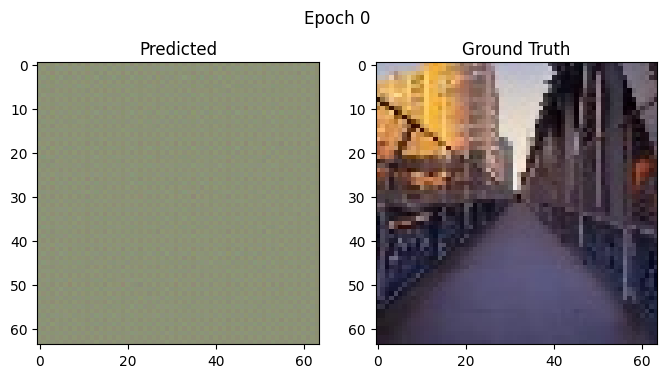

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 433854.53125


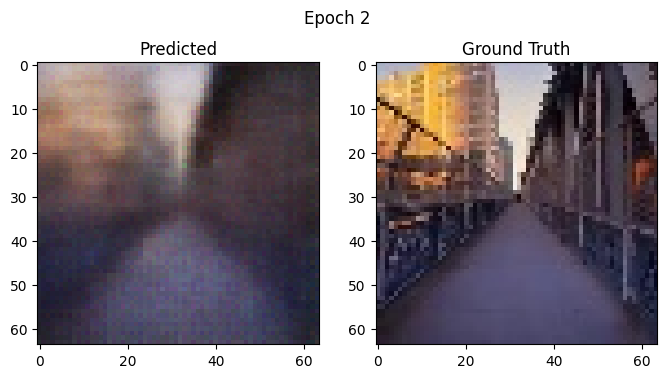

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 365336.46875


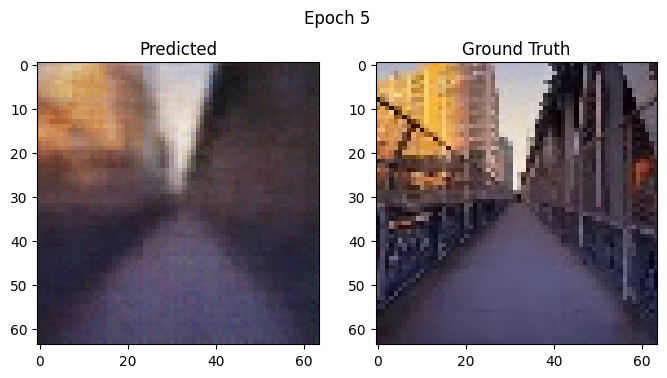

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 330297.9375


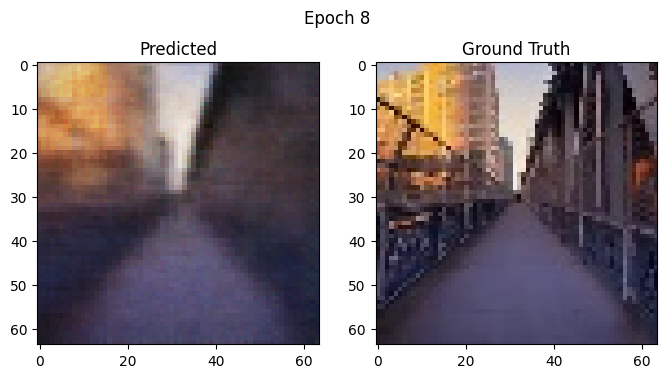

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 308203.5


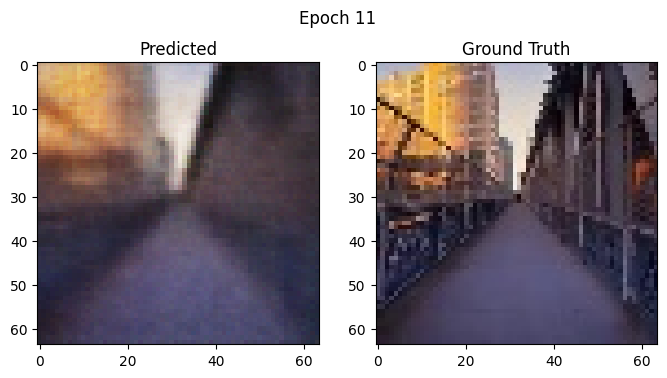

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 292702.8125


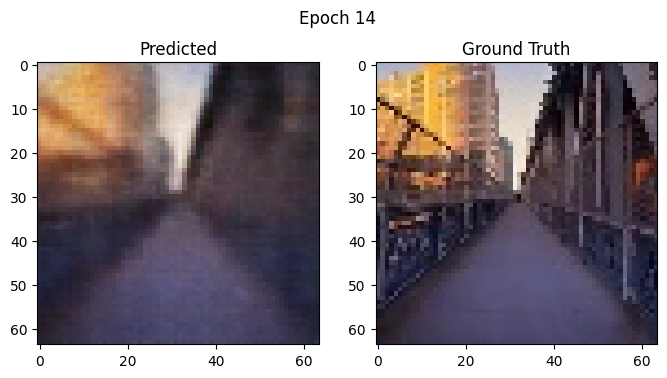

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 275503.40625


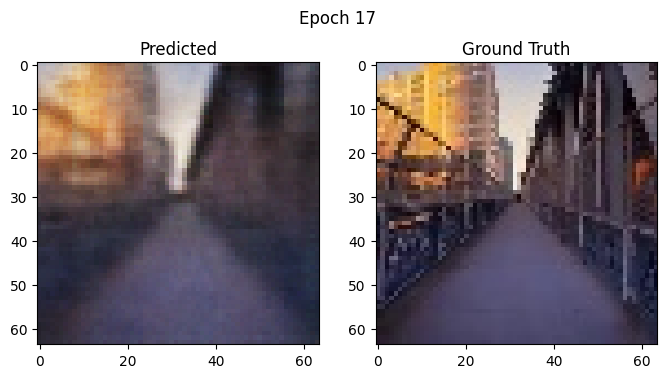

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 270378.25


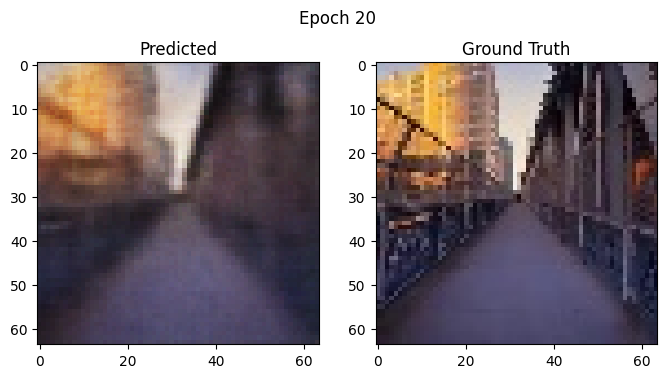

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 260656.796875


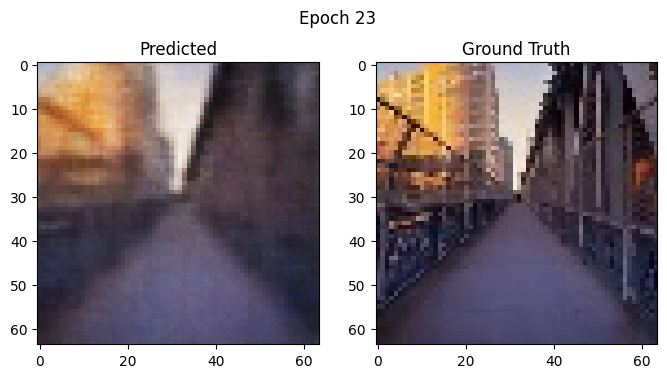

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 249094.671875


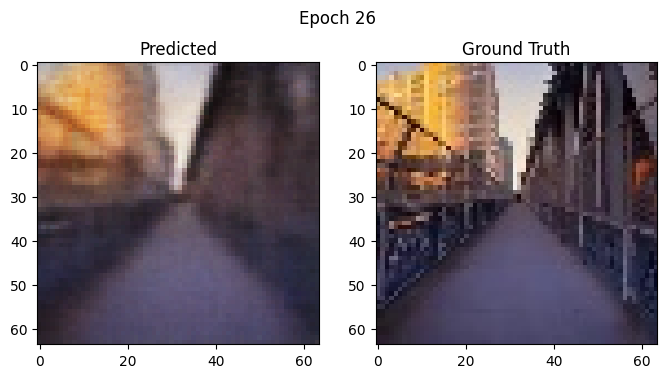

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 240685.84375


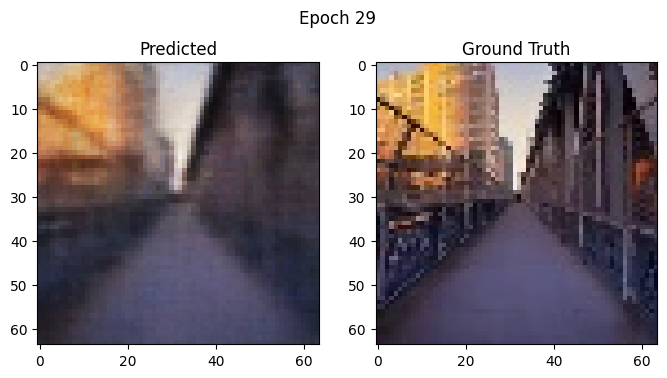

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
trainer_vae.fit(vae_trainer, train_loader_pickle, val_loader_pickle)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


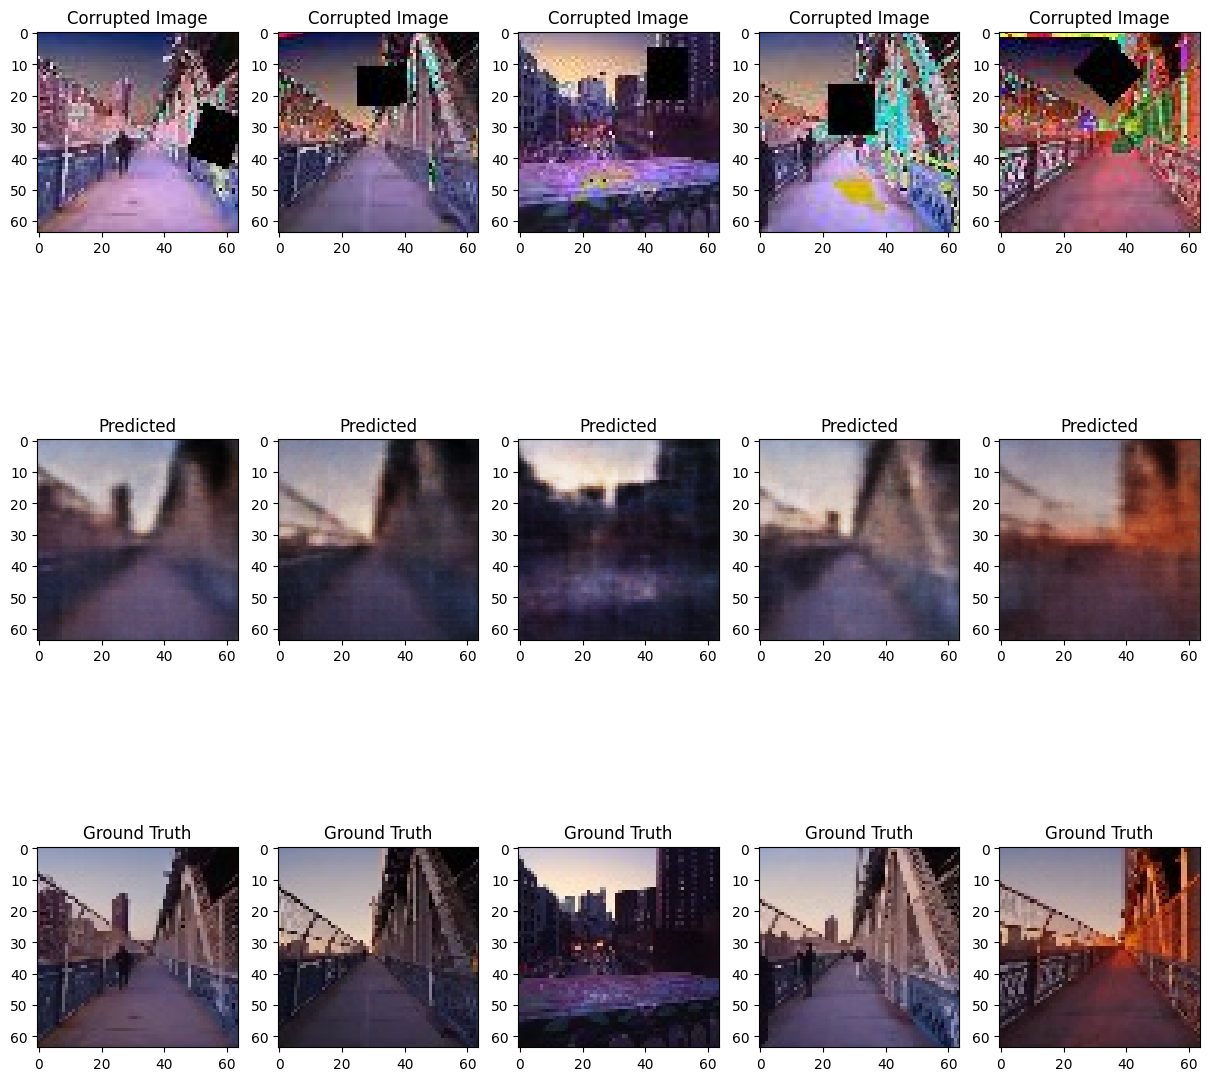

,MSE,NRMSE,PSNR,SSIM
max,0.014829,0.128676,27.979726,0.929291
mean,0.007048,0.086434,21.667964,0.623682
min,0.001410,0.039904,17.810019,0.341300


In [ ]:
vae_metrics = evaluate(vae_trainer, test_loader_pickle)

### Barlow Twins - VAE

#### Barlow Twins

In [14]:
encoder_bt = VAEEncoder(latent_dim=LATENT_DIM).to(device)

num_params = sum(p.numel() for p in encoder_bt.parameters())
print(f"Encoder BarlowTwins has {num_params} parameters.")

Encoder BarlowTwins has 2224000 parameters.


In [15]:
bt_trainer = BarlowTwins(encoder_bt, latent_channels=LATENT_DIM, learning_rate=1e-4, lambda_=5e-3)

In [16]:
trainer_bt = pl.Trainer(
    accelerator=device.type,
    max_epochs=15,
    check_val_every_n_epoch=1,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [17]:
trainer_bt.fit(bt_trainer, train_loader_pickle, val_loader_pickle)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | encoder      | VAEEncoder | 2.2 M  | train
1 | projector    | Sequential | 8.4 K  | train
2 | augmentation | Sequential | 0      | train
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.930     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss in epoch 0: 40.95186233520508


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 0: 13.311246871948242


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 1: 4.337639331817627


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 2: 1.8462013006210327


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 3: 1.2149174213409424


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 4: 0.8804649114608765


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 5: 0.9395657181739807


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 6: 0.7716410160064697


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 7: 0.748537003993988


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 8: 0.7091941237449646


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 9: 0.6742193698883057


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 10: 0.6706311702728271


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 11: 0.6458278894424438


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 12: 0.6180042624473572


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 13: 0.6223980188369751


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 14: 0.6529557108879089


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


#### VAE

In [18]:
vae_bt = VariationalAutoencoder(encoder_bt, latent_dim=LATENT_DIM).to(device)
num_params = sum(p.numel() for p in vae_bt.parameters())
print(f"Number of parameters: {num_params}")

vae_bt_trainer = VAETrainer(vae_bt, lr=1e-3)

Number of parameters: 4439299


In [19]:
trainer_vae_bt = pl.Trainer(
    accelerator=device.type,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 1819984.0


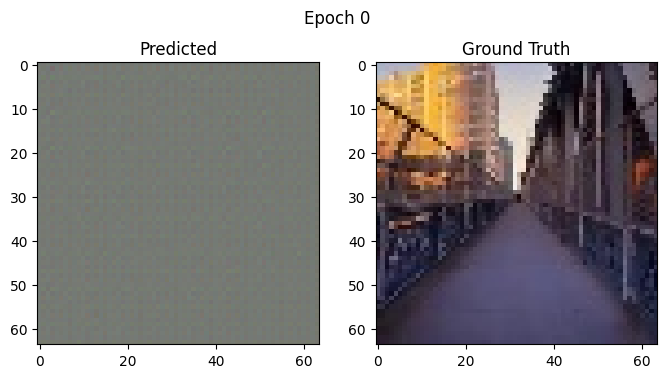

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 416355.15625


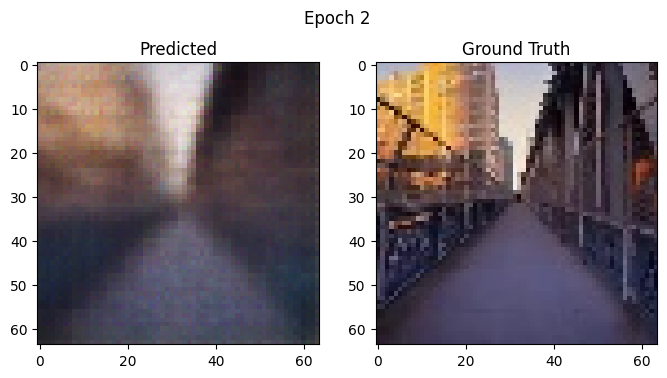

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 358368.15625


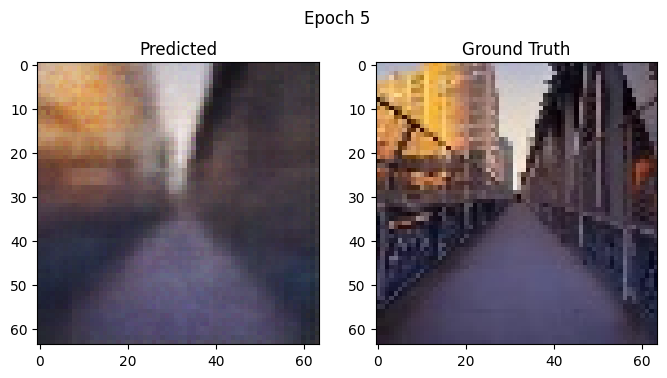

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 325869.65625


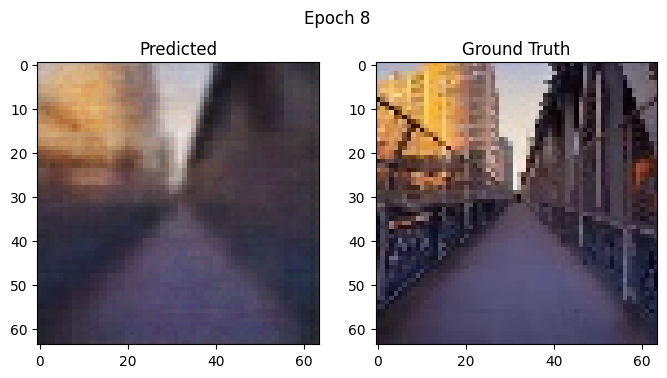

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 302427.0


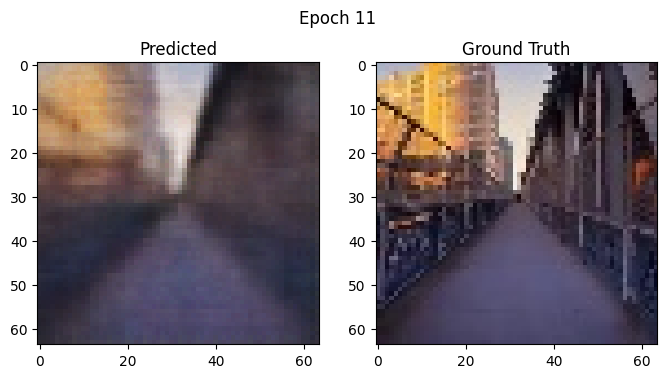

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 284898.1875


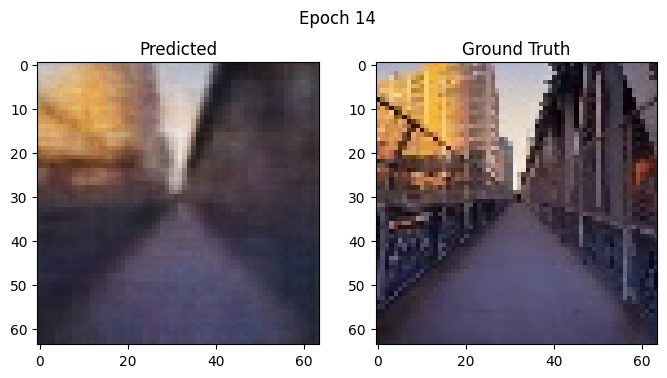

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 269006.53125


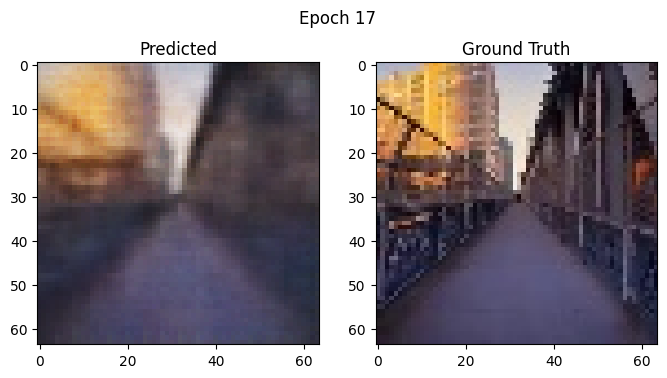

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 258866.25


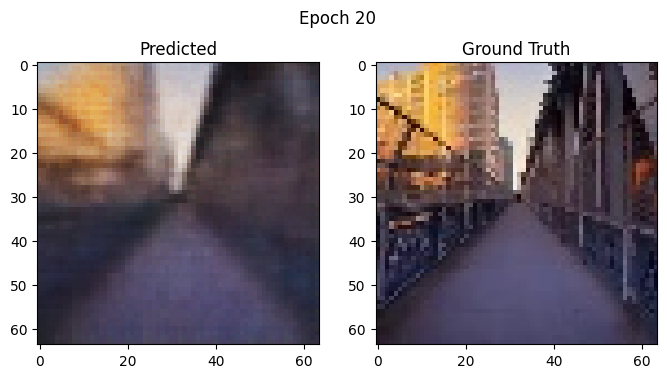

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 251972.0625


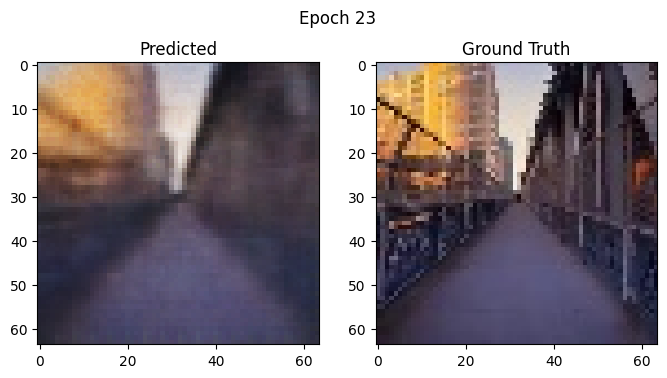

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 244103.25


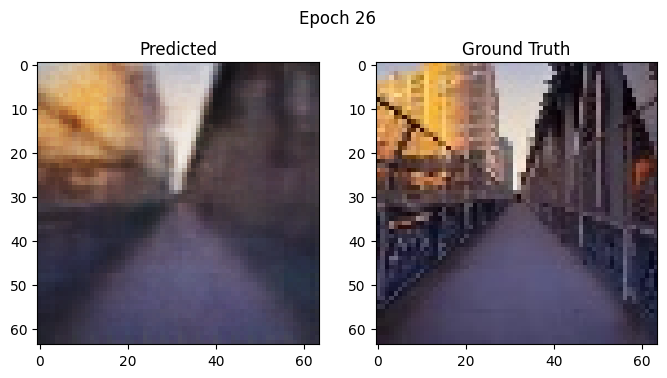

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 238030.828125


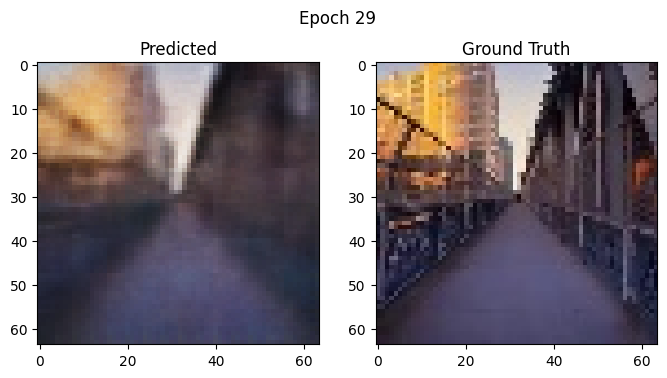

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [20]:
trainer_vae_bt.fit(vae_bt_trainer, train_loader_pickle, val_loader_pickle)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


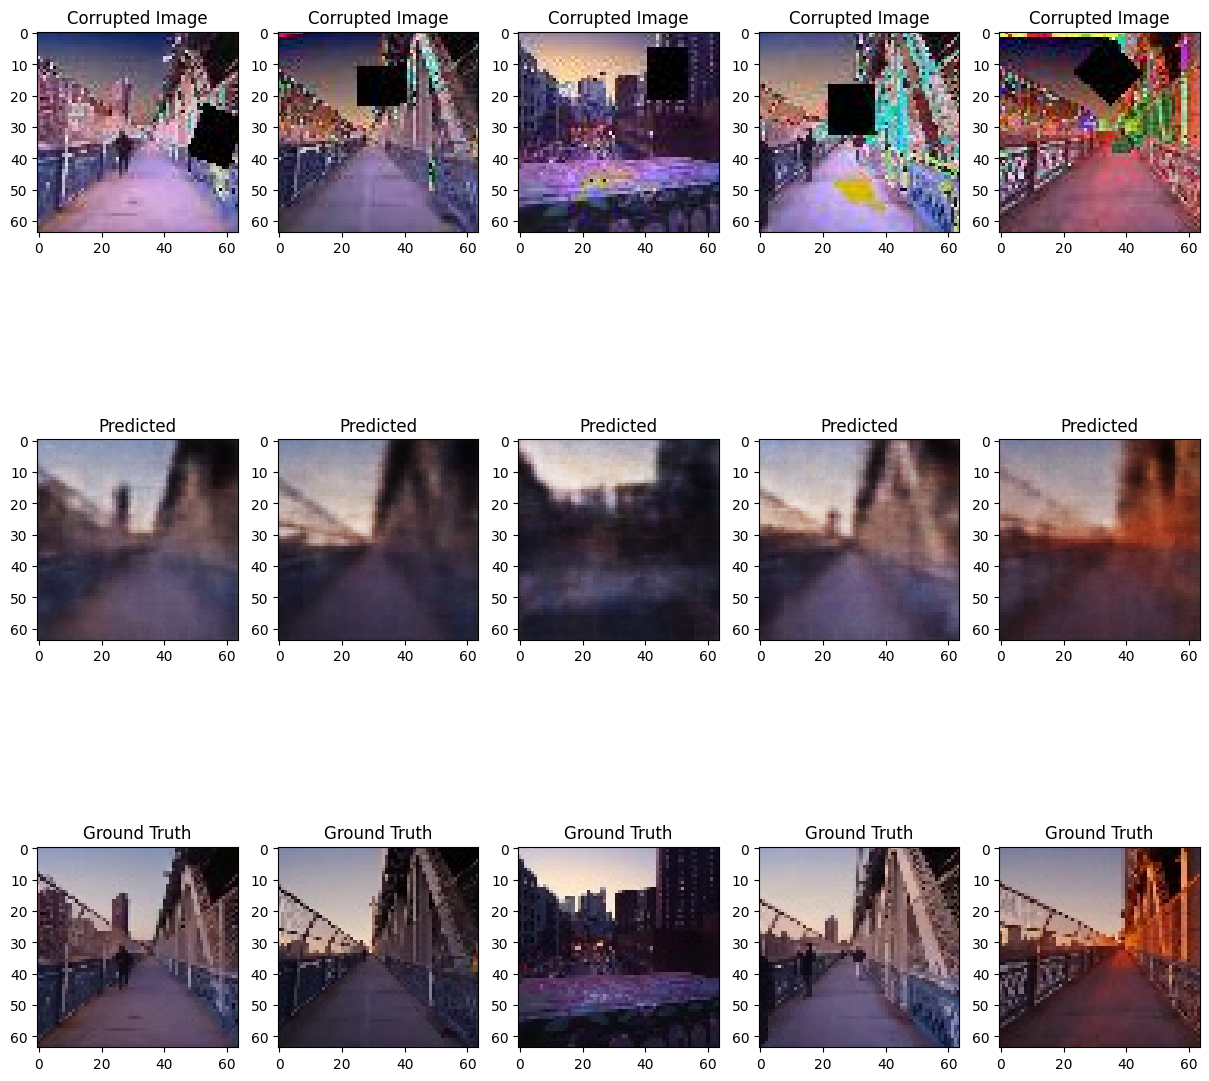

,MSE,NRMSE,PSNR,SSIM
max,0.018499,0.138411,27.978213,0.923744
mean,0.007425,0.088162,21.526056,0.621358
min,0.001470,0.039911,17.176594,0.340075


In [21]:
vae_bt_metrics = evaluate(vae_bt_trainer, test_loader_pickle)

### VAE - BarlowTwins - VAE

#### First VAE step

In [ ]:
encoder_vbv = VAEEncoder(latent_dim=LATENT_DIM).to(device)

vae_vbv = VariationalAutoencoder(encoder_vbv, latent_dim=LATENT_DIM).to(device)

vae_vbv_trainer = VAETrainer(vae_vbv, lr=1e-3)

trainer_vae_vbv1 = pl.Trainer(
    accelerator=device.type,
    max_epochs=10,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)


In [ ]:
trainer_vae_vbv1.fit(vae_vbv_trainer, train_loader_pickle, val_loader_pickle)

In [ ]:
_ = evaluate(vae_vbv_trainer, test_loader_pickle)

#### BarlowTwins step

In [ ]:
bt_vbv_trainer = BarlowTwins(encoder_vbv, latent_channels=LATENT_DIM, learning_rate=1e-4, lambda_=5e-3, lambda_kl=0)

trainer_bt_vbv = pl.Trainer(
    accelerator=device.type,
    max_epochs=15,
    check_val_every_n_epoch=1,
    limit_val_batches=1,
)

In [ ]:
trainer_bt_vbv.fit(bt_vbv_trainer, train_loader_pickle, val_loader_pickle)

#### Second VAE step

In [ ]:
trainer_vae_vbv2 = pl.Trainer(
    accelerator=device.type,
    max_epochs=20,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)

In [ ]:
trainer_vae_vbv2.fit(vae_vbv_trainer, train_loader_pickle, val_loader_pickle)

In [ ]:
vbv_metrics = evaluate(vae_vbv_trainer, test_loader_pickle)

### Results

In [ ]:
vae_metric = vae_metrics.describe().loc[["mean", "min", "max"]]
vae_bt_metric = vae_bt_metrics.describe().loc[["mean", "min", "max"]]
vbv_metric = vbv_metrics.describe().loc[["mean", "min", "max"]]

vae_metric['Model'] = 'VAE'
vae_bt_metric['Model'] = 'BarlowTwins-VAE'
vbv_metric['Model'] = 'VAE-BarlowTwins-VAE'

all_metrics = pd.concat([vae_metric, vae_bt_metric, vbv_metric])

display(all_metrics)

In [ ]:
mean_metrics = all_metrics.loc['mean']
mean_metrics = mean_metrics.set_index('Model')

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for idx, metric in enumerate(mean_metrics.columns):
    mean_metrics[metric].plot(kind='bar', ax=axs[idx], title=metric, color=['skyblue', 'salmon'])
    axs[idx].set_xticklabels(mean_metrics.index, rotation=90)
    axs[idx].set_ylabel(f'Value {metric}')
    axs[idx].set_xlabel('Model')

plt.suptitle('Comparison of results between VAE, BarlowTwins-VAE and VAE-BarlowTwins-VAE')
plt.tight_layout()
plt.show()

## Experiment with KL Lambda

### BarlowTwins - VAE

In [ ]:
def train_bt_vae(bt_epochs: int, vae_epochs: int, kl_lambda: float, latent_dim: int) -> pd.DataFrame:
    """
    Train the BarlowTwins and VAE models and evaluate the results.

    Parameters
    ----------
    bt_epochs : int
        Number of epochs to train the BarlowTwins model.
    vae_epochs : int
        Number of epochs to train the VAE model.
    kl_lambda : float
        Weight for the KL divergence loss in the VAE model.
    latent_dim : int
        Dimensionality of the latent space in the VAE model.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the mean evaluation metrics for the trained VAE model.

    """
    encoder = VAEEncoder(latent_dim=latent_dim).to(device)
    bt = BarlowTwins(encoder, latent_channels=latent_dim, learning_rate=1e-4, lambda_=5e-3, lambda_bt=1.0, kl_lambda=kl_lambda)
    print(f"BT training with {bt_epochs} epochs and kl_lambda={kl_lambda}")
    bt_trainer = pl.Trainer(
        accelerator=device.type,
        max_epochs=bt_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    bt_trainer.fit(bt, train_loader_pickle, val_loader_pickle)

    vae = VariationalAutoencoder(encoder, latent_dim=latent_dim).to(device)
    vae_trainer = VAETrainer(vae, lr=1e-3)
    trainer_vae = pl.Trainer(
        accelerator=device.type,
        max_epochs=vae_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    trainer_vae.fit(vae_trainer, train_loader_pickle, val_loader_pickle)

    metrics = evaluate(vae_trainer, test_loader_pickle)

    results = metrics.describe().loc[["mean"]]
    results['kl_lambda'] = kl_lambda

    return results

In [ ]:
kl_lambdas = [0, 0.3, 0.6, 1]
kl_lambda_results = pd.DataFrame()

for kl_lambda in kl_lambdas:
    res = train_bt_vae(10, 15, kl_lambda, 64)
    kl_lambda_results = pd.concat([kl_lambda_results, res], ignore_index=True)

In [ ]:
display(kl_lambda_results)

In [ ]:
kl_lambda_results = kl_lambda_results.set_index('kl_lambda')
kl_lambda_results.index = kl_lambda_results.index.astype(str)

colors = cm.winter(np.linspace(0, 1, len(kl_lambda_results.index)))
plt.style.use('ggplot')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].bar(kl_lambda_results.index, kl_lambda_results['MSE'], color=colors)
axs[0, 0].set_title('MSE')
axs[0, 0].set_xlabel('kl_lambda')
axs[0, 0].set_ylabel('MSE Value')

axs[0, 1].bar(kl_lambda_results.index, kl_lambda_results['NRMSE'], color=colors)
axs[0, 1].set_title('NRMSE')
axs[0, 1].set_xlabel('kl_lambda')
axs[0, 1].set_ylabel('NRMSE Value')

axs[1, 0].bar(kl_lambda_results.index, kl_lambda_results['PSNR'], color=colors)
axs[1, 0].set_title('PSNR')
axs[1, 0].set_xlabel('kl_lambda')
axs[1, 0].set_ylabel('PSNR Value')

axs[1, 1].bar(kl_lambda_results.index, kl_lambda_results['SSIM'], color=colors)
axs[1, 1].set_title('SSIM')
axs[1, 1].set_xlabel('kl_lambda')
axs[1, 1].set_ylabel('SSIM Value')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('BarlowTwins-VAE with different KL Lambda values')
plt.tight_layout()
plt.show()

### VAE - BarlowTwins - VAE

In [ ]:
def train_vbv(bt_epochs: int, vae_epochs: int, kl_lambda: float, latent_dim: int) -> pd.DataFrame:
    """
    Train the BarlowTwins and VAE models and evaluate the results.

    Parameters
    ----------
    bt_epochs : int
        Number of epochs to train the BarlowTwins model.
    vae_epochs : int
        Number of epochs to train the VAE model.
    kl_lambda : float
        Weight for the KL divergence loss in the VAE model.
    latent_dim : int
        Dimensionality of the latent space in the VAE model.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the mean evaluation metrics for the trained VAE model.

    """
    encoder = VAEEncoder(latent_dim=latent_dim).to(device)

    vae = VariationalAutoencoder(encoder, latent_dim=latent_dim).to(device)
    vae_trainer = VAETrainer(vae, lr=1e-3)

    trainer_vae1 = pl.Trainer(
        accelerator=device.type,
        max_epochs=int(vae_epochs//3),
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    print(f"VAE-1 training with {vae_epochs//3} epochs")
    trainer_vae1.fit(vae_trainer, train_loader_pickle, val_loader_pickle)

    barlow_twins = BarlowTwins(encoder, latent_channels=latent_dim, learning_rate=1e-4, lambda_=5e-3, lambda_bt=1.0, lambda_kl=kl_lambda)
    print(f"BT training with {bt_epochs} epochs and kl_lambda={kl_lambda}")
    bt_trainer = pl.Trainer(
        accelerator=device.type,
        max_epochs=bt_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    bt_trainer.fit(barlow_twins, train_loader_pickle, val_loader_pickle)


    trainer_vae2 = pl.Trainer(
        accelerator=device.type,
        max_epochs=int((2*vae_epochs) // 3),
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    print(f"VAE-2 training with {2*vae_epochs//3} epochs")
    trainer_vae2.fit(vae_trainer, train_loader_pickle, val_loader_pickle)

    metrics = evaluate(vae_trainer, test_loader_pickle)

    results = metrics.describe().loc[["mean"]]
    results['kl_lambda'] = kl_lambda

    return results

In [ ]:
kl_lambdas = [0, 0.3, 0.6, 1]
kl_lambda_vbv_results = pd.DataFrame()

for kl_lambda in kl_lambdas:
    res = train_vbv(10, 15, kl_lambda, 64)
    kl_lambda_vbv_results = pd.concat([kl_lambda_vbv_results, res], ignore_index=True)

In [ ]:
display(kl_lambda_vbv_results)

In [ ]:
kl_lambda_vbv_results = kl_lambda_vbv_results.set_index('kl_lambda')
kl_lambda_vbv_results.index = kl_lambda_vbv_results.index.astype(str)

colors = cm.winter(np.linspace(0, 1, len(kl_lambda_vbv_results.index)))

plt.style.use('ggplot')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['MSE'], color=colors)
axs[0, 0].set_title('MSE')
axs[0, 0].set_xlabel('kl_lambda')
axs[0, 0].set_ylabel('MSE Value')

axs[0, 1].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['NRMSE'], color=colors)
axs[0, 1].set_title('NRMSE')
axs[0, 1].set_xlabel('kl_lambda')
axs[0, 1].set_ylabel('NRMSE Value')

axs[1, 0].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['PSNR'], color=colors)
axs[1, 0].set_title('PSNR')
axs[1, 0].set_xlabel('kl_lambda')
axs[1, 0].set_ylabel('PSNR Value')

axs[1, 1].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['SSIM'], color=colors)
axs[1, 1].set_title('SSIM')
axs[1, 1].set_xlabel('kl_lambda')
axs[1, 1].set_ylabel('SSIM Value')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('VAE-BarlowTwins-VAE with different KL Lambda values')
plt.tight_layout()
plt.show()

## Results and Conclusions

**ToDo:** *Opis rezultatów -> czy wyniki potwierdza lub nie hipoteze badawczą + Tabele i wykresy*
